# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.157038,True,2.681995
1,-0.726820,True,4.937451
2,-0.851983,True,3.853603
3,-1.142982,False,0.293526
4,-1.328496,False,-1.103293
...,...,...,...
995,0.154200,False,1.227281
996,-1.373739,False,-1.253006
997,-0.565724,False,-0.558219
998,-3.728580,False,-4.900346


<Axes: xlabel='v0'>

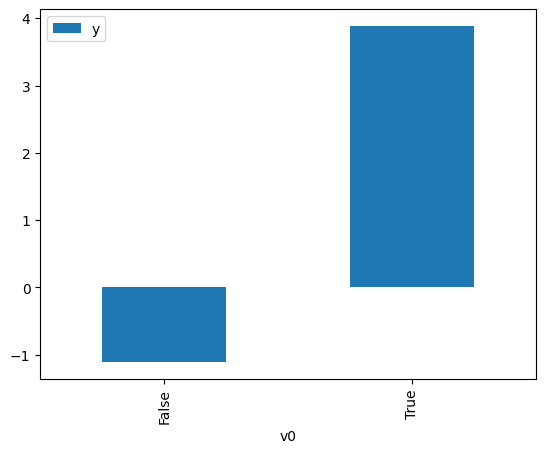

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

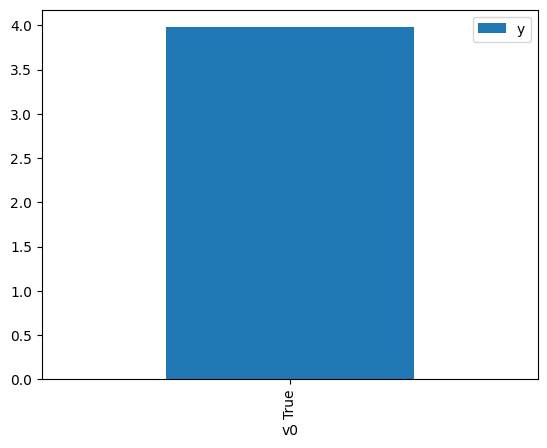

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.040635,False,-2.647663,0.672263,1.487514
1,2.333944,False,2.592661,0.152654,6.550755
2,-2.896817,False,-3.536812,0.886589,1.127919
3,0.612149,False,1.474335,0.383936,2.604604
4,-0.609887,False,-0.846952,0.600598,1.665007
...,...,...,...,...,...
995,-0.596945,False,-1.362010,0.598358,1.671240
996,0.616798,False,-0.344981,0.383143,2.609990
997,-0.312835,False,0.136137,0.548310,1.823786
998,-0.514042,False,-0.491333,0.583917,1.712573


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.832301,True,7.523489,0.652843,1.531761
1,-2.066590,True,2.257414,0.188783,5.297085
2,0.330099,True,5.686646,0.566989,1.763702
3,-0.242270,True,3.996321,0.464315,2.153709
4,-0.152484,True,3.025793,0.480444,2.081409
...,...,...,...,...,...
995,-1.183923,True,1.479729,0.305399,3.274403
996,0.198802,True,5.795142,0.543624,1.839508
997,-1.035670,True,3.661479,0.328526,3.043896
998,0.607826,True,6.858221,0.615327,1.625151


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              4907.
Date:                Tue, 18 Jul 2023   Prob (F-statistic):                        0.00
Time:                        15:58:06   Log-Likelihood:                         -1427.1
No. Observations:                1000   AIC:                                      2858.
Df Residuals:                     998   BIC:                                      2868.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2285      0.024     52.147      0.000       1.182       1.275
x2             5.0177      0.054     93.031      0.000       4.912       5.124
==============================================================================
Omnibus:                        3.454   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.398
Skew:                          -0.103   Prob(JB):                        0.183
Kurtosis:                       3.198   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""